In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from IPython.core.display import display, HTML
import pandas as pd

import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model, load_model
from keras import backend as K

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
display(HTML("<style>.container { width:90% !important; }</style>"))
plt.interactive(True)
%matplotlib inline
plt.rcParams['figure.figsize'] = [26, 6]

In [3]:
with open('../spectrograms_tugs.obj', 'rb') as specgram_file:
    patients = pickle.load(specgram_file)

specgrams = [patient['specgram'] for patient in patients]
print('Number of spectrograms: %s' % len(specgrams))

Number of spectrograms: 72


In [4]:
# Split dataset between train and test
train, X_test = train_test_split(specgrams, test_size=0.25, shuffle=False)
print('Training samples: ' + str(len(train)))
print('Test samples: ' + str(len(X_test)))

Training samples: 54
Test samples: 18


In [5]:
# Flip
X_train = []
for specgram in train:
    X_train.append(specgram)
    X_train.append(np.flip(specgram, 0))  # flip rows / y axis
    X_train.append(np.flip(specgram, 1))  # flip columns / x axis
    X_train.append(np.flip(specgram, (0, 1)))  # flip rows and columns / x and y axis

print(len(X_train))

216


In [6]:
# Obtain 3 dimensional shape
dim = X_train[0].shape
if len(dim) < 3:
    dim += (1,)
print(dim)

(20, 200, 1)


In [7]:
# Add gaussian noise
noise_factor = 0.05

X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=dim[:2])
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=dim[:2])

X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

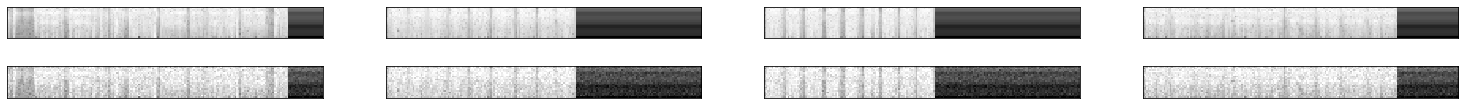

In [8]:
# Visualize original x noisy
n=4
plt.figure(figsize=(26, 2))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    ax.imshow(X_test[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i+n+1)
    ax.imshow(X_test_noisy[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [9]:
# Reshape images to be 3 dimensional
X_train = np.reshape(X_train, (len(X_train), dim[0], dim[1], dim[2]))
X_test = np.reshape(X_test, (len(X_test), dim[0], dim[1], dim[2]))

X_train_noisy = np.reshape(X_train_noisy, (len(X_train_noisy), dim[0], dim[1], dim[2]))
X_test_noisy = np.reshape(X_test_noisy, (len(X_test_noisy), dim[0], dim[1], dim[2]))

## Autoencoder Model

In [10]:
input_img = Input(shape=dim)

# encoder
code = Conv2D(32, kernel_size=(5, 5), padding='same', activation='relu')(input_img)
code = BatchNormalization()(code)
code = MaxPooling2D(pool_size=(2, 2))(code)
code = Conv2D(8, kernel_size=(5, 5), padding='same', activation='relu')(code)
code = BatchNormalization()(code)
code = MaxPooling2D(pool_size=(2, 2))(code)
code = Conv2D(2, kernel_size=(5, 5), padding='same', activation='relu')(code)
# code = MaxPooling2D(pool_size=(5, 5))(code)
# code = Conv2D(2, kernel_size=(5, 5), padding='same', activation='relu')(code)
bottleneck = Flatten()(code)

# decoder
x_hat = Reshape((5, 50, 2))(bottleneck)
x_hat = Conv2DTranspose(8, kernel_size=(5, 5), padding='same', activation='relu')(x_hat)
x_hat = BatchNormalization()(x_hat)
x_hat = UpSampling2D((2, 2))(x_hat)
x_hat = Conv2DTranspose(32, kernel_size=(5, 5), padding='same', activation='relu')(x_hat)
x_hat = BatchNormalization()(x_hat)
x_hat = UpSampling2D((2, 2))(x_hat)
x_hat = Conv2DTranspose(1, kernel_size=(5, 5), padding='same', activation='sigmoid')(x_hat)

autoencoder = Model(input_img, x_hat)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20, 200, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 200, 32)       832       
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 200, 32)       128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 100, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 100, 8)        6408      
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 100, 8)        32        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 50, 8)          0         
__________

In [11]:
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=50),
             ModelCheckpoint(filepath='best_model_TUGs_500.h5', monitor='val_loss', save_best_only=True)]

In [12]:
autoencoder.compile(loss='mean_squared_error', optimizer='adadelta')
# autoencoder.compile(loss='mse', optimizer='adam')

# tamanho do batch por iteracao
batch_size = 25

# número de épocas 
epochs = 250

# a variável history guarda os dados do processo de treinamento para posteriormente analisarmos
history = autoencoder.fit([X_train_noisy], [X_train],
                    batch_size=batch_size,
                    epochs=epochs,
                    shuffle=True,
                    callbacks=callbacks, # Early stopping
                    verbose=1,
                    validation_data=([X_test_noisy], [X_test]))

Train on 216 samples, validate on 18 samples
Epoch 1/250
216/216 [==============================] - 3s 12ms/step - loss: 0.0773 - val_loss: 0.0272
Epoch 2/250
216/216 [==============================] - 2s 9ms/step - loss: 0.0249 - val_loss: 0.0254
Epoch 3/250
216/216 [==============================] - 2s 9ms/step - loss: 0.0199 - val_loss: 0.0249
Epoch 4/250
216/216 [==============================] - 2s 9ms/step - loss: 0.0186 - val_loss: 0.0242
Epoch 5/250
216/216 [==============================] - 2s 9ms/step - loss: 0.0181 - val_loss: 0.0322
Epoch 6/250
216/216 [==============================] - 2s 9ms/step - loss: 0.0170 - val_loss: 0.0229
Epoch 7/250
216/216 [==============================] - 2s 9ms/step - loss: 0.0158 - val_loss: 0.0194
Epoch 8/250
216/216 [==============================] - 2s 9ms/step - loss: 0.0141 - val_loss: 0.0184
Epoch 9/250
216/216 [==============================] - 2s 9ms/step - loss: 0.0141 - val_loss: 0.0136
Epoch 10/250
216/216 [=======================

Epoch 81/250
216/216 [==============================] - 2s 9ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 82/250
216/216 [==============================] - 2s 9ms/step - loss: 0.0034 - val_loss: 0.0028
Epoch 83/250
216/216 [==============================] - 2s 9ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 84/250
216/216 [==============================] - 2s 10ms/step - loss: 0.0032 - val_loss: 0.0042
Epoch 85/250
216/216 [==============================] - 2s 9ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 86/250
216/216 [==============================] - 2s 9ms/step - loss: 0.0043 - val_loss: 0.0049
Epoch 87/250
216/216 [==============================] - 2s 9ms/step - loss: 0.0034 - val_loss: 0.0028
Epoch 88/250
216/216 [==============================] - 2s 10ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 89/250
216/216 [==============================] - 2s 9ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 90/250
216/216 [==============================] - 2s 9ms/step - loss: 0.00

216/216 [==============================] - 2s 9ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 240/250
216/216 [==============================] - 2s 9ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 241/250
216/216 [==============================] - 2s 9ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 242/250
216/216 [==============================] - 2s 9ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 243/250
216/216 [==============================] - 2s 9ms/step - loss: 0.0030 - val_loss: 0.0021
Epoch 244/250
216/216 [==============================] - 2s 9ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 245/250
216/216 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 246/250
216/216 [==============================] - 2s 9ms/step - loss: 0.0028 - val_loss: 0.0034
Epoch 247/250
216/216 [==============================] - 2s 9ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 248/250
216/216 [==============================] - 2s 9ms/step - loss: 0.0027 - v

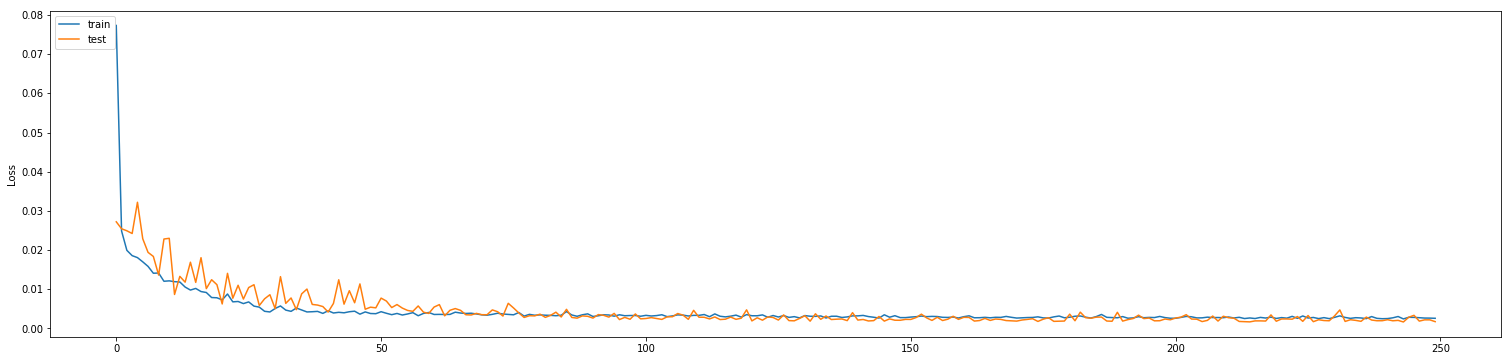

In [13]:
# utilizando o histórico: o gráfico da função de custo ao longo das épocas
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
# load best model
autoencoder = load_model('best_model_TUGs_500.h5')

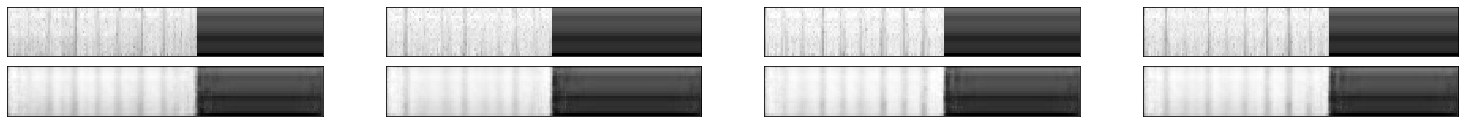

In [15]:
decoded_test = np.reshape(X_test, (len(X_test), dim[0], dim[1]))
decoded_predictions = autoencoder.predict([X_test])
decoded_predictions = np.reshape(decoded_predictions, (len(decoded_predictions), dim[0], dim[1]))

plt.figure(figsize=(26, 2))
start, stop = 10, 14
for i, n in enumerate(range(start, stop), start=1):
    ax = plt.subplot(2, stop-start, i)
    plt.imshow(decoded_test[n], cmap='gray', aspect='auto')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, stop-start, i+stop-start)
    plt.imshow(decoded_predictions[n], cmap='gray', aspect='auto')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()